In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import date
from datetime import timedelta
import calendar
import time
%matplotlib inline
from pathlib import Path 
import os
from matplotlib.ticker import ScalarFormatter
from matplotlib import ticker

# Setting up Directories and Paths

In [2]:
#Find yesterday's date and convert it to string
today=date.today()
yesterday=today-timedelta(days=1)
ydate=yesterday.strftime("%d-%m-%Y")
todate=today.strftime("%d-%m-%Y")
year=str(yesterday.year)
month=calendar.month_name[yesterday.month]

#Specify Data folder
data_folder = Path("../data")

#Compute filename
data_file = ydate + ".csv"

#Compute complete filepath for the day
file_path = data_folder / data_file

#Set Chart Folder
chart_folder= Path("../charts")

#Create Year Folder
year_folder=chart_folder/year

try:
    os.mkdir(year_folder)
    print('New Directory Created for this year')
except:
    print("Directory already exists")
    
# Create Month Folder
month_folder=year_folder/month
try:
    os.mkdir(month_folder)
    print('New Directory Created for this month')
except:
    print("Directory already exists")

#Create Date Folder
date_folder=month_folder/ydate
try:
    os.mkdir(date_folder)
    print('New Directory Created for today')
except:
    print("Directory already exists")

Directory already exists
Directory already exists
Directory already exists


In [3]:
state_name='Tamil Nadu'

#Set Export Path for State in Date Folder
state_path=date_folder/state_name
try:
    os.mkdir(state_path)
    print('New Directory Created for today')
except:
    print("Directory already exists")

New Directory Created for today


# Analysis

In [4]:
#Read file to data frame
df=pd.read_csv(file_path)

df['Date']= pd.to_datetime(df['Date'], dayfirst=True)
df=df[df['Date']!=today] #Drop today's data
df_h=df[df['Status']=='Hospitalized']
df_r=df[df['Status']=='Recovered']
df_d=df[df['Status']=='Deceased']

C:\Users\joses\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\joses\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """


In [5]:
tamilnadu=df_h[df_h['State']=='Tamil Nadu']
tamilnadu=pd.DataFrame(tamilnadu.groupby(['Date', 'District'])['Num_Cases'].sum())
tamilnadu.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)
dist_daily=tamilnadu.pivot_table(index='Date', columns='District', fill_value=0)

In [6]:
#Create a time series for TN Districts by Cumulative Cases 
dist_cum=dist_daily.cumsum()
dist_cum.rename(columns={'Daily New Cases':'Cumulative Cases'}, inplace=True)

In [7]:
#Arrange districts in descending order of latest cumulative Cases
trans=dist_cum.transpose()
sort_dist=pd.DataFrame(trans[yesterday].sort_values(ascending=False))
mylist=sort_dist.index.tolist() #Export to a list (Array of Cumulative Cases and District names)

In [8]:
dist_list=[row[1] for row in mylist]#Creates a new list from the array above and extracts only the district names
#Split the States into three different categories according to their rank
top12=dist_list[0:12] #Top 12 districts
second12=dist_list[12:24] #13-24 Districts
last=dist_list[24:] #Last 14 Districts

In [9]:
#Select Top 12 Districts by Cumulative Cases
top12cum=pd.DataFrame()
for i in range(12):
    top12cum[top12[i]]=dist_cum['Cumulative Cases', top12[i]]

In [10]:
#Select the second 12 districts by Cumulative Cases
second12cum=pd.DataFrame()
for i in range(12):
    second12cum[second12[i]]=dist_cum['Cumulative Cases', second12[i]]

In [11]:
#Select Top 12 Districts by Daily New Cases
top12new=pd.DataFrame()
for i in range(12):
    top12new[top12[i]]=dist_daily['Daily New Cases', top12[i]]

In [12]:
#Select the second 12 Districts by Daily New Cases
second12new=pd.DataFrame()
for i in range(12):
    second12new[second12[i]]=dist_daily['Daily New Cases', second12[i]]

In [13]:
#Calculate 7-Day Rolling Average for Top 12 Districts
top12new7dra=pd.DataFrame()
for i in range(12):
    name=top12new.columns[i]
    top12new7dra[name]= top12new.iloc[:,i].rolling(window=7).mean()

top12new7dra2=pd.DataFrame()
for i in range(12):
    name=top12new7dra.columns[i]
    top12new7dra2[name]=top12new7dra.iloc[:,i]
top12new7dra2.reset_index(drop=True,inplace=True)

#Extract Data after First Detected Case
top12new7dra_dat2=pd.DataFrame()
for j in range(12):
    for i in range(60):
        if top12new7dra2.iloc[i,j] > 0.1:
            x=top12new7dra2[top12new7dra2.columns[j]].iloc[i:]
            x.reset_index(drop=True, inplace=True)
            top12new7dra_dat2=pd.concat([top12new7dra_dat2,x],axis=1)
            break


# Top 13-24 Districts

In [14]:
#Calculate 7-Day Rolling Average for Top 13-24 States
second12new7dra=pd.DataFrame()
for i in range(12):
    name=second12new.columns[i]
    second12new7dra[name]= second12new.iloc[:,i].rolling(window=7).mean()


second12new7dra2=pd.DataFrame()
for i in range(12):
    name=second12new7dra.columns[i]
    second12new7dra2[name]=second12new7dra.iloc[:,i]
second12new7dra2.reset_index(drop=True,inplace=True)

#Extract Data after First Detected Case
second12new7dra_dat2=pd.DataFrame()
for j in range(12):
    for i in range(60):
        if second12new7dra2.iloc[i,j] > 0.1:
            x=second12new7dra2[second12new7dra2.columns[j]].iloc[i:]
            x.reset_index(drop=True, inplace=True)
            second12new7dra_dat2=pd.concat([second12new7dra_dat2,x],axis=1)
            break

In [15]:
#Graph Starting date is 23rd April; Calculate number of days as integer
y=(today-date(2020,3,23)).days

In [16]:
#Daily New Cases for Tamilnadu
tn=df_h[df_h['State']=='Tamil Nadu']
tn_daily=pd.DataFrame(tn.groupby('Date')['Num_Cases'].sum())
tn_daily.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)

In [17]:
#Calculate the 7 day Rolling Average for Daily New Cases in TN
tn_daily_7dra=pd.DataFrame()
tn_daily_7dra[tn_daily.columns[0]]=tn_daily.iloc[:,0].rolling(window=7).mean()
tn_daily_7dra.rename(columns={'Daily New Cases':'Daily New Cases (7-Day Rolling Average)'}, inplace=True)

In [18]:
#Cumulative Cases for Tamilnadu
tn_cum=tn_daily.cumsum()
tn_cum.rename(columns={'Daily New Cases':'Cumulative Cases'}, inplace=True)

In [19]:
source="Source: www.covid19india.org"
ytitle1="Number of Cases --->"
ytitle2="7-day Rolling Average"
daf = "Days after First Detected Case --->"
credit="Created by: Dr. Joseph S, MD"
update="Data updated till " + todate + " 08:00 AM"

# Plots Start Here

In [20]:
from matplotlib.pyplot import *
def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return '%1i' % (x)

formatter = FuncFormatter(log_10_product)

#Create a function of footers
def footer1():
    plt.figtext(0.40, 0.04, credit, horizontalalignment='left')
    plt.figtext(0.40, 0.02, source, horizontalalignment='left')
    plt.figtext(0.40, 0.0, update, horizontalalignment='left')

def footer2():
    plt.figtext(0.45, 0.02, credit, horizontalalignment='left')
    plt.figtext(0.45, 0.0, source, horizontalalignment='left')
    plt.figtext(0.45, -0.02, update, horizontalalignment='left')
    
def footer3():
    plt.figtext(0.72, 0.04, credit, horizontalalignment='left')
    plt.figtext(0.72, 0.02, source, horizontalalignment='left')
    plt.figtext(0.72, 0.0, update, horizontalalignment='left')
    
lw=2.5

C:\Users\joses\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


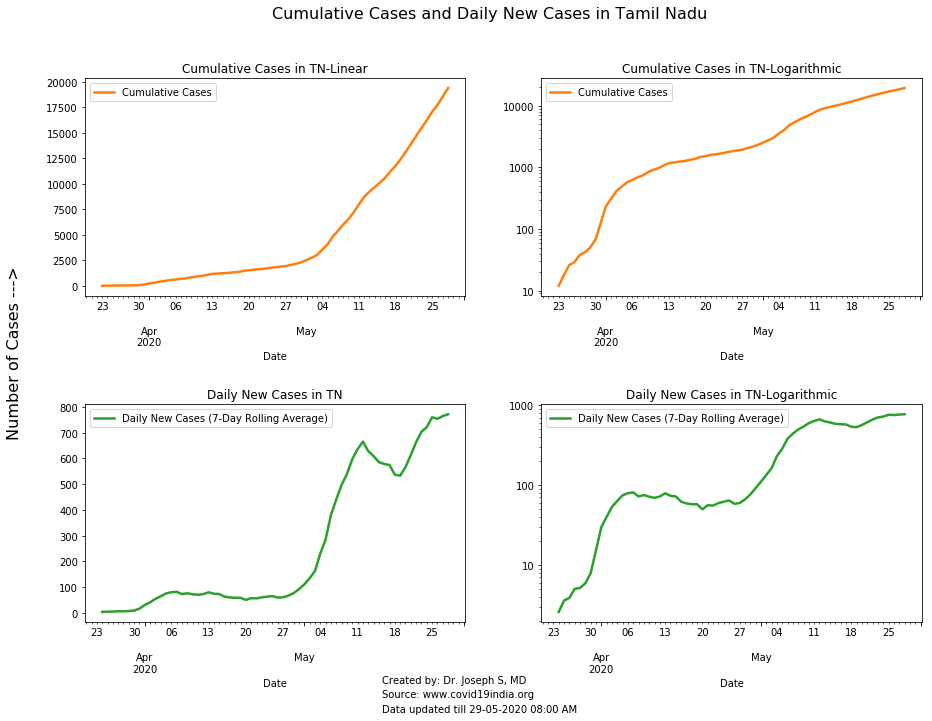

In [21]:
#Sub plots for TN
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
figtit="Cumulative Cases and Daily New Cases in Tamil Nadu"

tn_cum.tail(y).plot(kind='line', ax=axes[0,0], color='C1', linewidth=lw, title='Cumulative Cases in TN-Linear')
tn_cum.tail(y).plot(kind='line', ax=axes[0,1], color='C1', linewidth=lw, title='Cumulative Cases in TN-Logarithmic').set_yscale('log')
axes[0,1].yaxis.set_major_formatter(formatter)
tn_daily_7dra.tail(y).plot(kind='line', ax=axes[1,0], color='C2', linewidth=lw, title='Daily New Cases in TN')
tn_daily_7dra.tail(y).plot(kind='line', ax=axes[1,1], color='C2', linewidth=lw, title='Daily New Cases in TN-Logarithmic').set_yscale('log')
axes[1,1].yaxis.set_major_formatter(formatter)
fig.suptitle(figtit, fontsize=16)
footer1()
fig.text(0.06, 0.5, ytitle1, ha='center', va='center', rotation='vertical', fontsize=16)


figtit="1 "+figtit+".jpg"
figpath=state_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

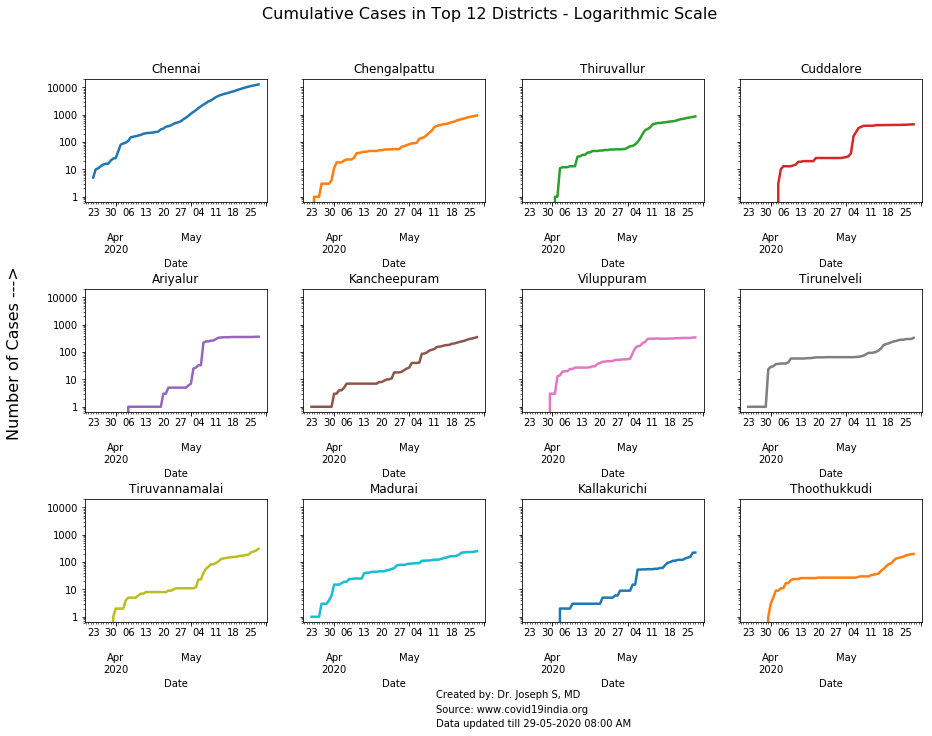

In [22]:
#Subplots for Top 12 Districts Cumulative
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.7)
figtit="Cumulative Cases in Top 12 Districts - Logarithmic Scale"

for i in range(3):
    for j in range(4):
        a=(i*4)+j
        b=a%10
        c="C"+str(b)
        top12cum[top12cum.columns[a]].tail(y).plot(kind='line', ax=axes[i,j], color=c, linewidth=lw, title=top12cum.columns[a]).set_yscale('log')
        axes[i,j].yaxis.set_major_formatter(formatter)

fig.suptitle(figtit, fontsize=16)
footer2()
fig.text(0.06, 0.5, ytitle1, ha='center', va='center', rotation='vertical', fontsize=16)

figtit="2 "+figtit+".jpg"
figpath=state_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

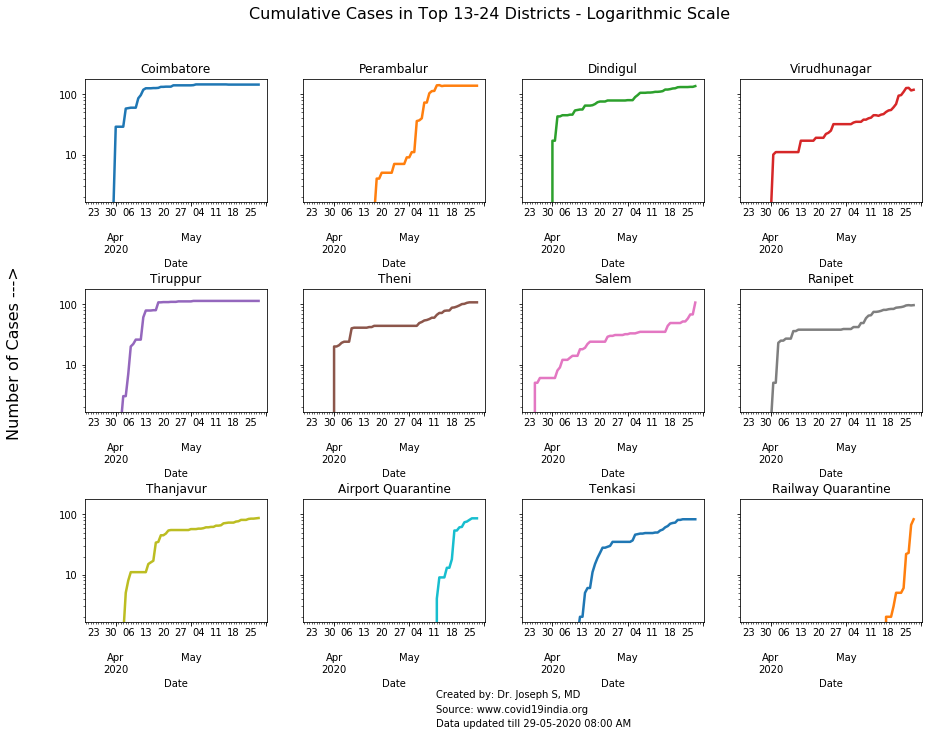

In [23]:
#Sub plots for top 13-24 Districts Cumulative
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.7)
figtit="Cumulative Cases in Top 13-24 Districts - Logarithmic Scale"

for i in range(3):
    for j in range(4):
        a=(i*4)+j
        b=a%10
        c="C"+str(b)
        second12cum[second12cum.columns[a]].tail(y).plot(kind='line', ax=axes[i,j], color=c, linewidth=lw, title=second12cum.columns[a]).set_yscale('log')
        axes[i,j].yaxis.set_major_formatter(formatter)

fig.suptitle(figtit, fontsize=16)
footer2()
fig.text(0.06, 0.5, ytitle1, ha='center', va='center', rotation='vertical', fontsize=16)

figtit="3 "+figtit+".jpg"
figpath=state_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

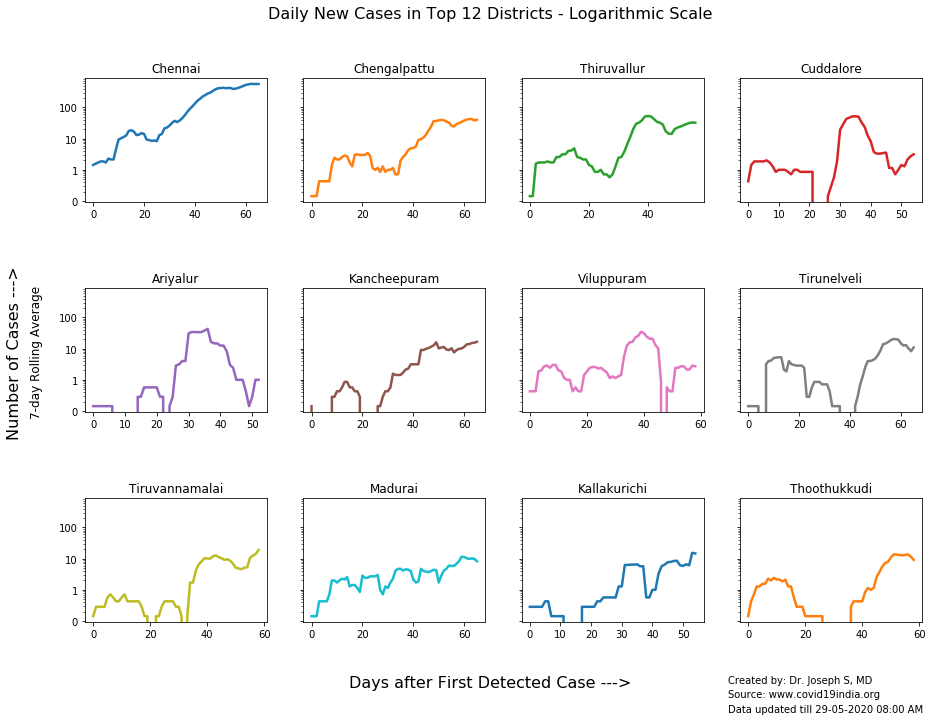

In [24]:
#Subplots for Daily New Cases - Top 12 Districts

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.7)
figtit="Daily New Cases in Top 12 Districts - Logarithmic Scale"

for i in range(3):
    for j in range(4):
        a=(i*4)+j
        b=a%10
        c="C"+str(b)
        top12new7dra_dat2[top12new7dra_dat2.columns[a]].plot(kind='line', ax=axes[i,j], color=c, linewidth=lw, title=top12new7dra_dat2.columns[a]).set_yscale('log')
        axes[i,j].yaxis.set_major_formatter(formatter)

fig.suptitle(figtit, fontsize=16)
footer3()
fig.text(0.5, 0.04, daf, ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, ytitle1, ha='center', va='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.5, ytitle2, ha='center', va='center', rotation='vertical', fontsize=12)

figtit="4 "+figtit+".jpg"
figpath=state_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

IndexError: index 11 is out of bounds for axis 0 with size 11

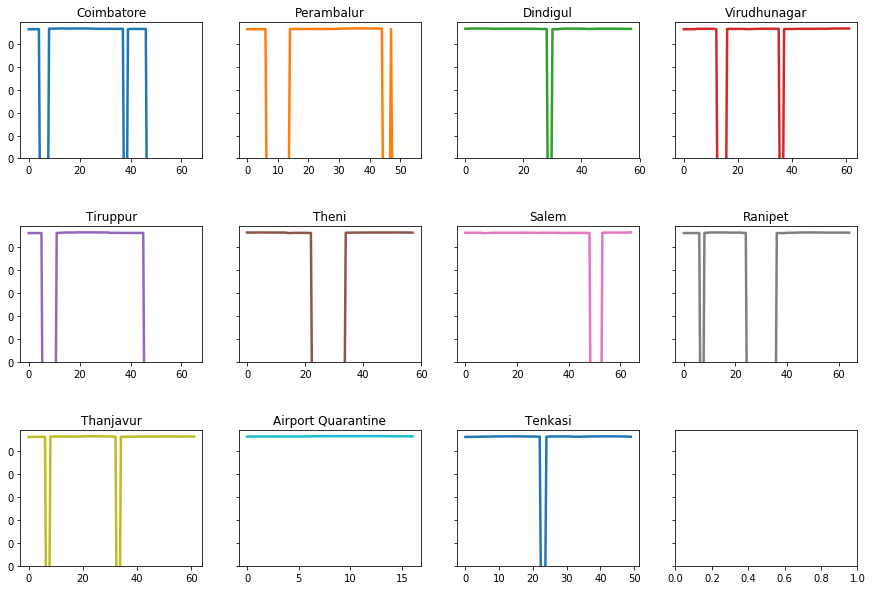

In [25]:
#Subplots for Daily New Cases - Top 13-24 Districts
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.5)
figtit="Daily New Cases in Top 13-24 Districts - Logarithmic Scale"


for i in range(3):
    for j in range(4):
        a=(i*4)+j
        b=a%10
        c="C"+str(b)
        second12new7dra_dat2[second12new7dra_dat2.columns[a]].plot(kind='line', ax=axes[i,j], color=c, linewidth=lw, title=second12new7dra_dat2.columns[a]).set_yscale('log')
        axes[i,j].yaxis.set_major_formatter(formatter)

fig.suptitle(figtit, fontsize=16)
footer3()
fig.text(0.5, 0.04, daf, ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, ytitle1, ha='center', va='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.5, ytitle2, ha='center', va='center', rotation='vertical', fontsize=12)

figtit="5 "+figtit+".jpg"
figpath=state_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()